### Hybrid SLR + CNN Colorization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
import os

IMAGE_DIM = 128 # What the model resizes dataset into and what it predicts

In [ ]:

def extract_datas(V_true, w, device='cpu'):
    H, W = V_true.shape[:2]
    Y_true = torch.tensordot(V_true, w, dims=1)
    Ks = []  # ignore kernels for model
    Z = torch.empty(H * W, 0, device=device)
    V_target = V_true.reshape(-1, 3)
    Y_target = Y_true.reshape(-1)
    return Z, V_target, Y_target, Y_true


def compute_orthonormal_basis(w, device='cpu'):
    w_norm = w / torch.norm(w)
    tmp = torch.tensor([1., 0., 0.], device=device) if abs(w_norm[0]) < 0.9 else torch.tensor([0., 1., 0.], device=device)
    u1 = tmp - w_norm * torch.dot(tmp, w_norm)
    u1 = u1 / (torch.norm(u1) + 1e-8)
    u2 = torch.linalg.cross(w_norm, u1)
    u2 = u2 / (torch.norm(u2) + 1e-8)
    return u1, u2


def reconstruct_color(Y_target, alpha, beta, w, u1, u2):
    w2 = torch.dot(w, w)
    v_parallel = (Y_target / w2).unsqueeze(1) * w
    v_perp = alpha.unsqueeze(1) * u1 + beta.unsqueeze(1) * u2
    return v_parallel + v_perp


### Hybrid Model: CNN + SLR
Fixed feature extractor (Sobel, Laplacian, Identity)

In [ ]:

class FixedFeatureExtractor(nn.Module):
    """
    Computes z_{ij} = [Sobel_x, Sobel_y, Laplacian, Identity] features from Y.
    Output: [B, 4, H, W]. Kernels are frozen (not trainable).
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False)
        self._init_kernels()
        for p in self.parameters():
            p.requires_grad = False

    def _init_kernels(self):
        sobel_x = torch.tensor([
            [-1., 0., 1.],
            [-2., 0., 2.],
            [-1., 0., 1.],
        ])
        sobel_y = torch.tensor([
            [-1., -2., -1.],
            [ 0.,  0.,  0.],
            [ 1.,  2.,  1.],
        ])
        laplacian = torch.tensor([
            [ 0.,  1.,  0.],
            [ 1., -4.,  1.],
            [ 0.,  1.,  0.],
        ])
        identity = torch.tensor([
            [0., 0., 0.],
            [0., 1., 0.],
            [0., 0., 0.],
        ])

        kernels = torch.stack([sobel_x, sobel_y, laplacian, identity], dim=0)  # [4,3,3]
        with torch.no_grad():
            self.conv.weight.copy_(kernels.unsqueeze(1))  # [4,1,3,3]

    def forward(self, Y):  # Y: [B,1,H,W]
        return self.conv(Y)  # [B,4,H,W]

# CNN + SLR
class HybridColorizationCNN(nn.Module):
    def __init__(self, m_features=4):
        super().__init__()

        self.m = m_features
        self.fixed_features = FixedFeatureExtractor()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.tbn1 = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.tbn2 = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2 * self.m, 4, stride=2, padding=1)

    def forward(self, L):
        with torch.no_grad():
            z = self.fixed_features(L)
        x = F.relu(self.bn1(self.conv1(L)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.tbn1(self.tconv1(x)))
        x = F.relu(self.tbn2(self.tconv2(x)))
        x = self.tconv3(x)
        A, B = torch.chunk(x, 2, dim=1)
        alpha_hat = (A * z).sum(dim=1, keepdim=True)
        beta_hat  = (B * z).sum(dim=1, keepdim=True)
        return alpha_hat, beta_hat


### Baseline CNN Model

In [ ]:

class BaseColorizationCNN(nn.Module):
    """Predicts alpha and beta (coefficients in orthonormal color basis)"""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 32 x H/2 x W/2
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 64 x H/4 x W/4
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 128 x H/8 x W/8
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)


        self.tconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.tbn1 = nn.BatchNorm2d(64)

        self.tconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.tbn2 = nn.BatchNorm2d(32)

        self.tconv3 = nn.ConvTranspose2d(32, 2, 4, stride=2, padding=1)

    def forward(self, L):
        x = F.relu(self.bn1(self.conv1(L)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.tbn1(self.tconv1(x)))
        x = F.relu(self.tbn2(self.tconv2(x)))
        x = self.tconv3(x)   # final alpha,beta
        a = x[:, 0:1]
        b = x[:, 1:2]
        return a, b

###  CIFAR-10 data loader: 32x32

In [ ]:

def load_cifar10(batch_size=64):
    train_transform = transforms.Compose([
      transforms.Resize(144),
      transforms.CenterCrop(IMAGE_DIM),
      transforms.RandomHorizontalFlip(),   # augmentation
      transforms.RandomRotation(10),       # augmentation
      transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(144),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
    ])
    # transform = transforms.Compose([transforms.ToTensor()])

    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader


### Flowers102 data loader: 128x128

In [ ]:

def load_flowers102(batch_size=64):
    train_transform = transforms.Compose([
      transforms.Resize(144),
      transforms.CenterCrop(IMAGE_DIM),
      transforms.RandomHorizontalFlip(),   # augmentation
      transforms.RandomRotation(10),       # augmentation
      transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(144),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
    ])
    # transform = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor()])

    train_ds = datasets.Flowers102(root="./data", split='train', download=True, transform=train_transform)
    test_ds = datasets.Flowers102(root="./data", split='test', download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

### STL10 data loader: 96x96

In [ ]:

def load_stl10(batch_size=64):
    train_transform = transforms.Compose([
      transforms.Resize(144),
      transforms.CenterCrop(IMAGE_DIM),
      transforms.RandomHorizontalFlip(),   # augmentation
      transforms.RandomRotation(10),       # augmentation
      transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(144),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
    ])
    train_ds = datasets.STL10(root="./data", split='unlabeled', download=True, transform=train_transform)
    train_ds_mini = datasets.STL10(root="./data", split='train', download=True, transform=train_transform)
    train_ds = torch.utils.data.ConcatDataset([train_ds, train_ds_mini])
    test_ds = datasets.STL10(root="./data", split='test', download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

###  Training & Evaluation

In [ ]:

def train_one_epoch(model, loader, w, u1, u2, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, _ in loader:
        imgs = imgs.to(device)
        Y = (imgs * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)
        optimizer.zero_grad()
        a_pred, b_pred = model(Y)
        alpha, beta = a_pred.permute(0,2,3,1).reshape(-1), b_pred.permute(0,2,3,1).reshape(-1)
        Y_flat = Y.permute(0,2,3,1).reshape(-1)
        V_target = imgs.permute(0, 2, 3, 1).reshape(-1, 3)
        V_pred = reconstruct_color(Y_flat, alpha, beta, w, u1, u2)
        loss = ((V_pred - V_target) ** 2).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def evaluate(model, loader, w, u1, u2, device):
    model.eval()
    total_loss = 0
    for imgs, _ in loader:
        imgs = imgs.to(device)
        Y = (imgs * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)
        a_pred, b_pred = model(Y)
        alpha, beta = a_pred.permute(0,2,3,1).reshape(-1), b_pred.permute(0,2,3,1).reshape(-1)
        Y_flat = Y.permute(0,2,3,1).reshape(-1)
        V_target = imgs.permute(0, 2, 3, 1).reshape(-1, 3)
        V_pred = reconstruct_color(Y_flat, alpha, beta, w, u1, u2)
        total_loss += ((V_pred - V_target) ** 2).mean().item()
    return total_loss / len(loader)


###  Display plots

In [ ]:

def show_plots(train_losses, val_losses):
    # Training Loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", color="blue", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Validation Loss
    plt.figure(figsize=(8,5))
    plt.plot(val_losses, label="Validation Loss", color="orange", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

###  Display predictions

In [ ]:

@torch.no_grad()
def predict_dataset_images(model, loader, w, u1, u2, device, num_images=5, randomize=False):
    model.eval()
    imgs, _ = next(iter(loader))
    if randomize:
        idx = torch.randperm(imgs.size(0))[:num_images]
        imgs = imgs[idx]

    imgs = imgs.to(device)
    Y = (imgs * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)
    a_pred, b_pred = model(Y)

    n = min(num_images, imgs.size(0))
    fig, axes = plt.subplots(n, 3, figsize=(9, 3 * n))

    for i in range(n):
        alpha = a_pred[i].permute(1,2,0).reshape(-1)
        beta  = b_pred[i].permute(1,2,0).reshape(-1)
        Y_true = Y[i].permute(1,2,0).reshape(-1)

        V_pred = reconstruct_color(Y_true, alpha, beta, w, u1, u2)
        V_pred = V_pred.reshape(*imgs.shape[2:], 3).clamp(0, 1).cpu().numpy()

        gray = Y[i, 0].cpu().numpy()
        gt = imgs[i].permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(gray, cmap="gray")
        axes[i, 0].set_title(f"Gray {i+1}")
        axes[i, 1].imshow(V_pred)
        axes[i, 1].set_title("Hybrid Predicted")
        axes[i, 2].imshow(gt)
        axes[i, 2].set_title("Ground Truth")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

###  Predict single image

In [ ]:
@torch.no_grad()
def predict_single_image(model, img, w, u1, u2, device):
    """
    Predict single image of any dimension.
    """
    model.eval()

    # 1. Standardize input to torch tensor
    if isinstance(img, np.ndarray):
        img = Image.fromarray((img * 255).astype("uint8")) if img.max() <= 1 else Image.fromarray(img)
        img = transforms.Resize((IMAGE_DIM, IMAGE_DIM))(img)
        img = transforms.ToTensor()(img)

    if isinstance(img, PIL.Image.Image):
        img = transforms.Resize((IMAGE_DIM, IMAGE_DIM))(img)
        img = transforms.ToTensor()(img)

    if img.dim() == 3 and img.shape[0] == 3:
        # correct shape: (C,H,W)
        pass
    else:
        raise ValueError("Image must be (C,H,W) with 3 channels")

    # Move to device
    img = img.unsqueeze(0).to(device)        # → (1,3,H,W)

    C, H, W = img.shape[1:]                  # dynamic dimensions

    # ------------------------------------------
    # 2. Convert to luminance Y
    # ------------------------------------------
    Y = (img * w.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)   # → (1,1,H,W)

    # ------------------------------------------
    # 3. Model prediction
    # ------------------------------------------
    a_pred, b_pred = model(Y)                # both → (1,1,H,W)

    # ------------------------------------------
    # 4. Reconstruct RGB from (Y, α, β)
    # ------------------------------------------
    # Extract data
    alpha = a_pred[0].permute(1,2,0).reshape(-1)
    beta  = b_pred[0].permute(1,2,0).reshape(-1)
    Y_vec = Y[0].permute(1,2,0).reshape(-1)

    V_pred = reconstruct_color(Y_vec, alpha, beta, w, u1, u2)
    V_pred = V_pred.reshape(H, W, 3).clamp(0, 1).cpu().numpy()

    # Ground truth for comparison
    gt = img[0].permute(1,2,0).cpu().numpy()
    gray = Y[0, 0].cpu().numpy()

    # ------------------------------------------
    # 5. Plot
    # ------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    axes[0].imshow(gray, cmap="gray")
    axes[0].set_title("Grayscale")

    axes[1].imshow(V_pred)
    axes[1].set_title("Predicted Color")

    axes[2].imshow(gt)
    axes[2].set_title("Ground Truth")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return V_pred

In [ ]:

# =========================================================
#  Save the model
# =========================================================
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


In [ ]:

# =========================================================
#  Load the model
# =========================================================
def load_model(model_class, path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    print(f"Model loaded from {path}")
    return model

###  Train model

In [ ]:
def train_model(model_class, load_dataset_function, batch_size, epochs=50, early_stopping=True, save_path="colorizer.pth"):
    print(f"=== Training {model_class.__name__} ===")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    # Luminance setup and color basis
    w = torch.tensor([0.299, 0.587, 0.114], device=device)
    u1, u2 = compute_orthonormal_basis(w, device=device)

    train_loader, test_loader = load_dataset_function(batch_size=batch_size)

    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Lr = learning rate

    train_losses = []
    val_losses = []

    # Early stopping
    best_val_loss = float('inf')
    patience = 7  # stop after this many epochs if no improvement
    patience_counter = 0
    best_state_dict = None

    for epoch in range(1, epochs + 1):
        tr = train_one_epoch(model, train_loader, w, u1, u2, optimizer, device)
        va = evaluate(model, test_loader, w, u1, u2, device)

        train_losses.append(tr)
        val_losses.append(va)

        print(f"Epoch {epoch:02d} | Train Loss: {tr:.6f} | Val Loss: {va:.6f}")

        if early_stopping:
            if va < best_val_loss:
                best_val_loss = va
                patience_counter = 0
                best_state_dict = model.state_dict()
            else:
                patience_counter += 1
                print(f"No improvement ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    if early_stopping and best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    save_model(model, save_path)
    show_plots(train_losses, val_losses)


## Training

=== Training HybridColorizationCNN ===
Device: cuda
Epoch 01 | Train Loss: 0.053355 | Val Loss: 0.031344
Epoch 02 | Train Loss: 0.022912 | Val Loss: 0.042001
Epoch 03 | Train Loss: 0.021394 | Val Loss: 0.026261
Epoch 04 | Train Loss: 0.020922 | Val Loss: 0.021627
Epoch 05 | Train Loss: 0.020420 | Val Loss: 0.021683
Epoch 06 | Train Loss: 0.020221 | Val Loss: 0.021830
Epoch 07 | Train Loss: 0.020039 | Val Loss: 0.021093
Epoch 08 | Train Loss: 0.020046 | Val Loss: 0.021838
Epoch 09 | Train Loss: 0.019782 | Val Loss: 0.020974
Epoch 10 | Train Loss: 0.019869 | Val Loss: 0.021137
Epoch 11 | Train Loss: 0.019879 | Val Loss: 0.021206
Epoch 12 | Train Loss: 0.020179 | Val Loss: 0.022227
Epoch 13 | Train Loss: 0.019722 | Val Loss: 0.020946
Epoch 14 | Train Loss: 0.019608 | Val Loss: 0.020874
Epoch 15 | Train Loss: 0.019475 | Val Loss: 0.020680
Epoch 16 | Train Loss: 0.019566 | Val Loss: 0.021080
Epoch 17 | Train Loss: 0.019406 | Val Loss: 0.020717
Epoch 18 | Train Loss: 0.019300 | Val Loss: 0.0

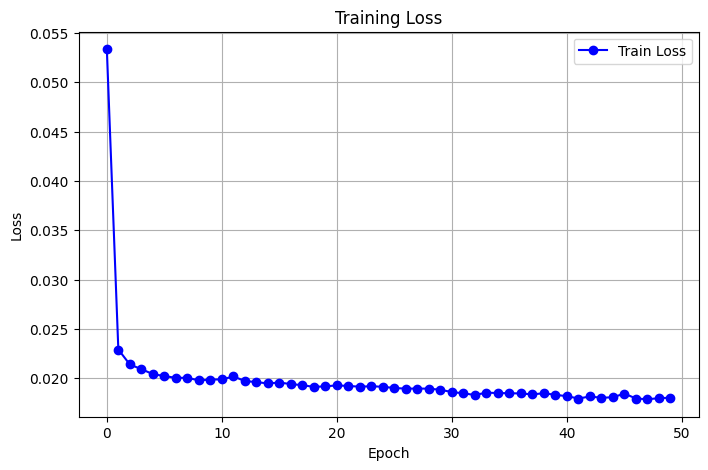

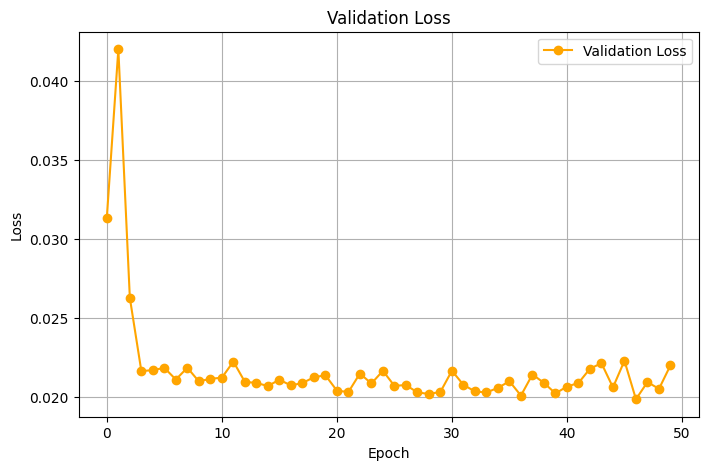

=== Training BaseColorizationCNN ===
Device: cuda
Epoch 01 | Train Loss: 0.094738 | Val Loss: 0.036140
Epoch 02 | Train Loss: 0.031700 | Val Loss: 0.029995
Epoch 03 | Train Loss: 0.027478 | Val Loss: 0.028050
Epoch 04 | Train Loss: 0.025566 | Val Loss: 0.026379
Epoch 05 | Train Loss: 0.024602 | Val Loss: 0.025669
Epoch 06 | Train Loss: 0.023984 | Val Loss: 0.024889
Epoch 07 | Train Loss: 0.024119 | Val Loss: 0.024939
Epoch 08 | Train Loss: 0.023416 | Val Loss: 0.023981
Epoch 09 | Train Loss: 0.023051 | Val Loss: 0.024088
Epoch 10 | Train Loss: 0.022679 | Val Loss: 0.023641
Epoch 11 | Train Loss: 0.022584 | Val Loss: 0.024025
Epoch 12 | Train Loss: 0.022358 | Val Loss: 0.023128
Epoch 13 | Train Loss: 0.022326 | Val Loss: 0.023282
Epoch 14 | Train Loss: 0.021885 | Val Loss: 0.024101
Epoch 15 | Train Loss: 0.021898 | Val Loss: 0.023344
Epoch 16 | Train Loss: 0.021930 | Val Loss: 0.022832
Epoch 17 | Train Loss: 0.021738 | Val Loss: 0.022643
Epoch 18 | Train Loss: 0.021717 | Val Loss: 0.023

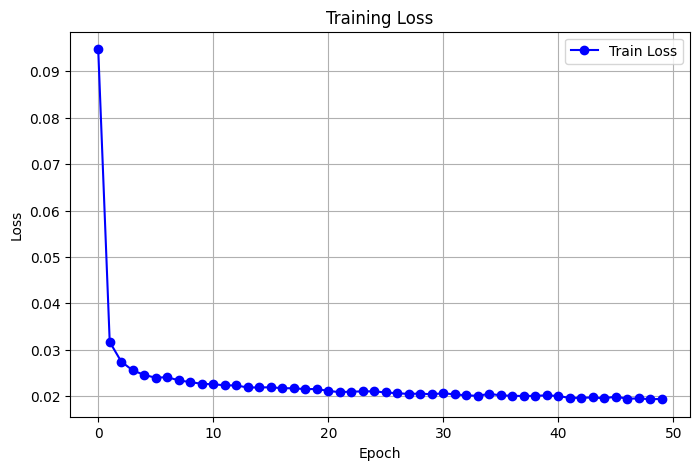

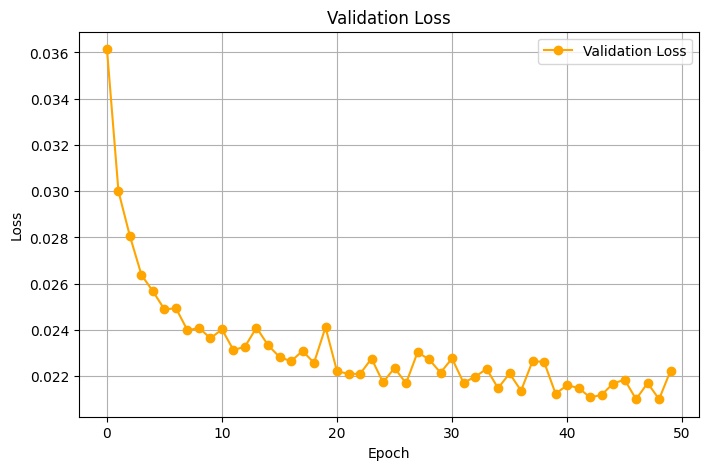

In [ ]:
train_model(HybridColorizationCNN, load_flowers102, batch_size=64, epochs=50, early_stopping=False, save_path="hybrid_colorizer.pth")
train_model(BaseColorizationCNN, load_flowers102, batch_size=64, epochs=50, early_stopping=False, save_path="base_colorizer.pth")

## Testing

Device: cuda
Model loaded from hybrid_colorizer.pth
Model loaded from base_colorizer.pth
Predicting test_imgs/bean.jpg


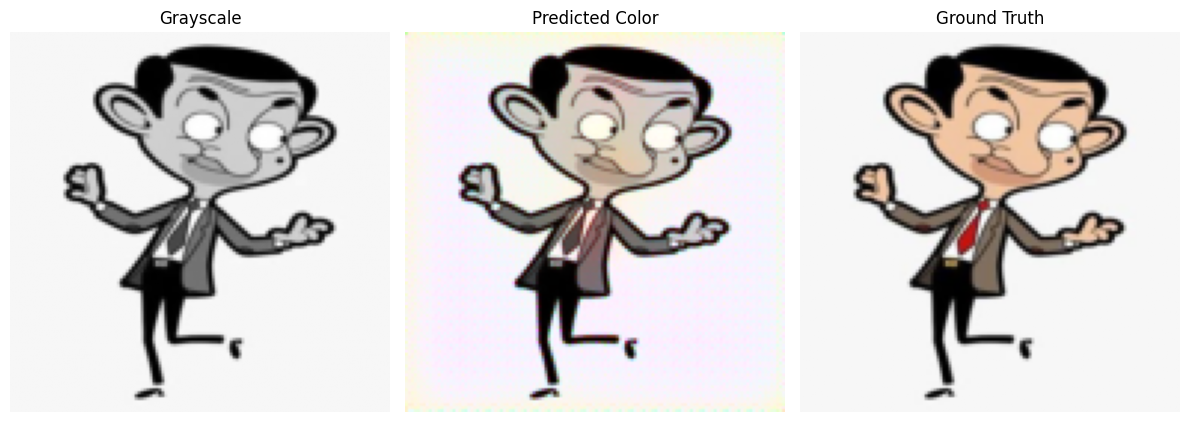

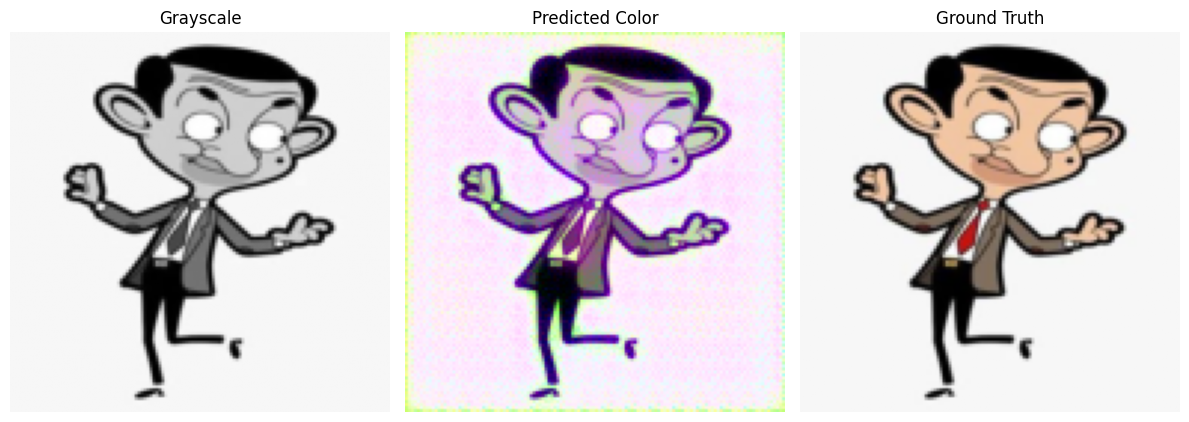

Predicting test_imgs/colorful-stained-glass-stockcake.jpg


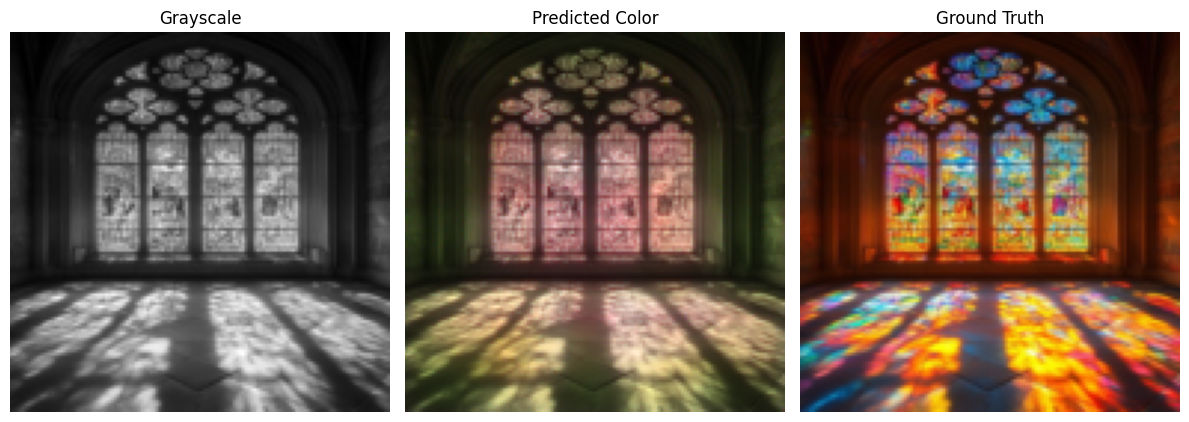

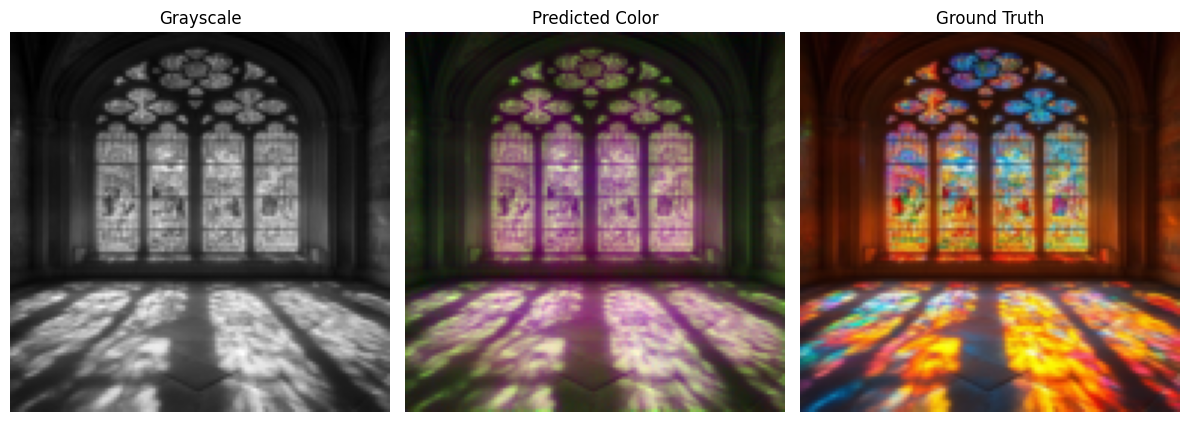

Predicting test_imgs/assumption-of-mary-detail-min.jpg


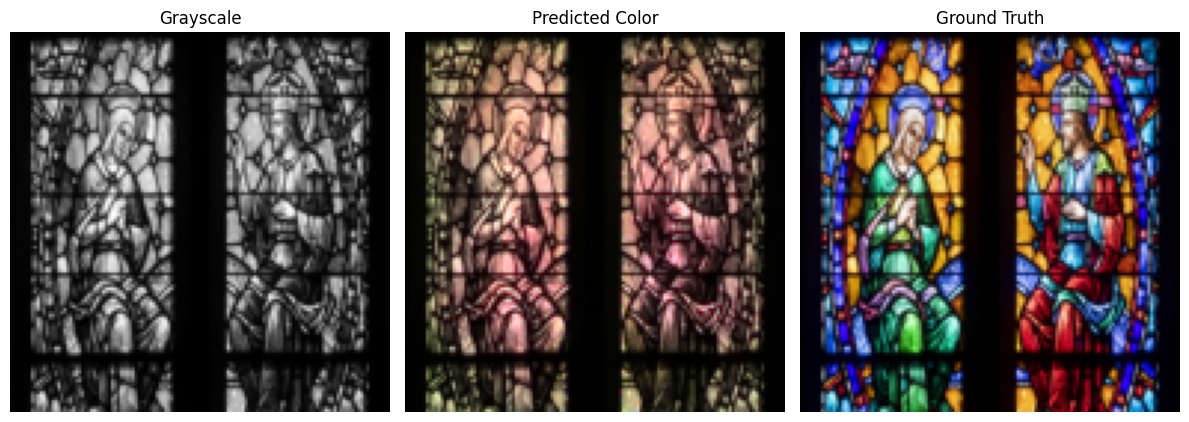

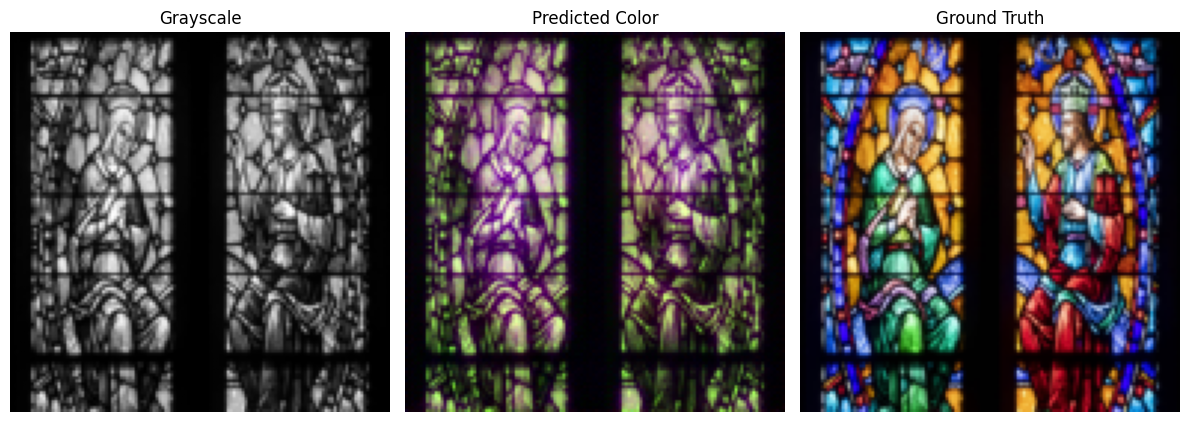

Predicting test_imgs/poo.jpg


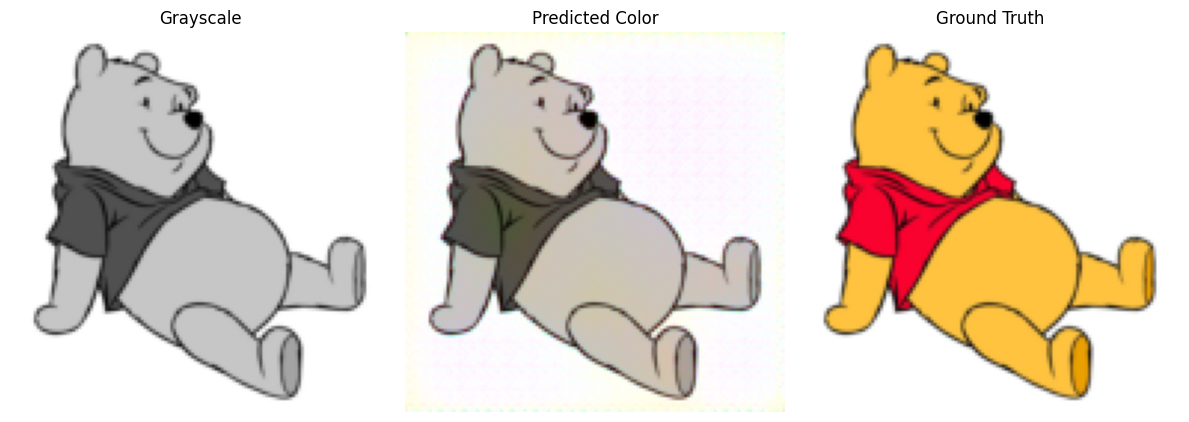

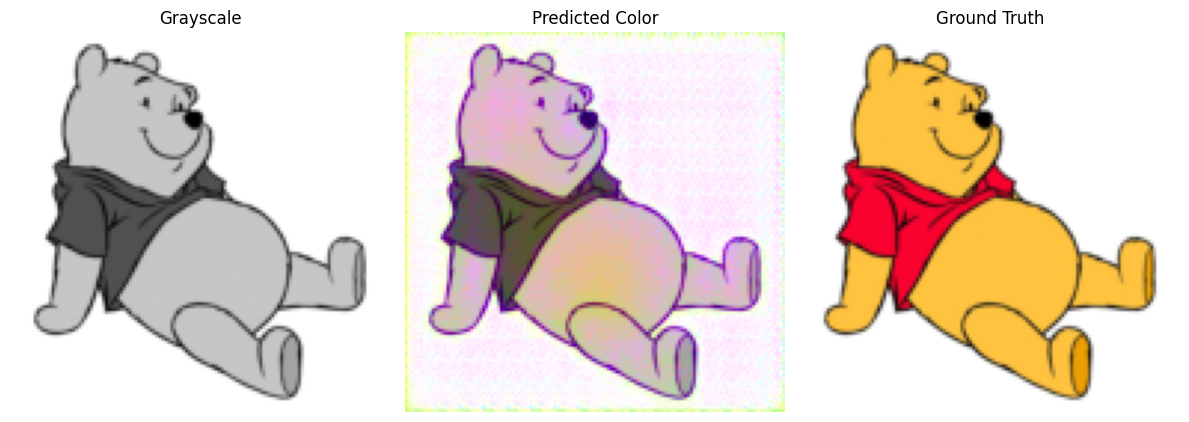

Predicting test_imgs/Rose_window.jpg


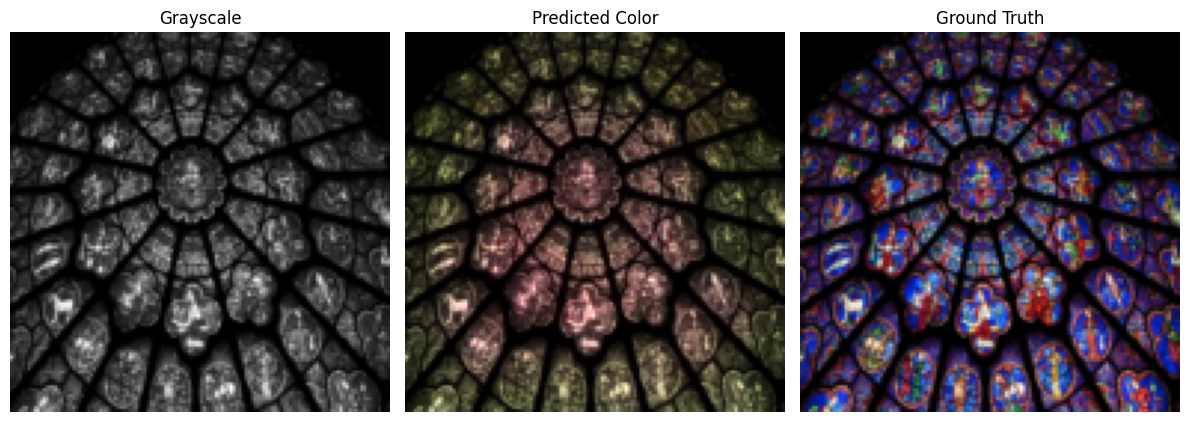

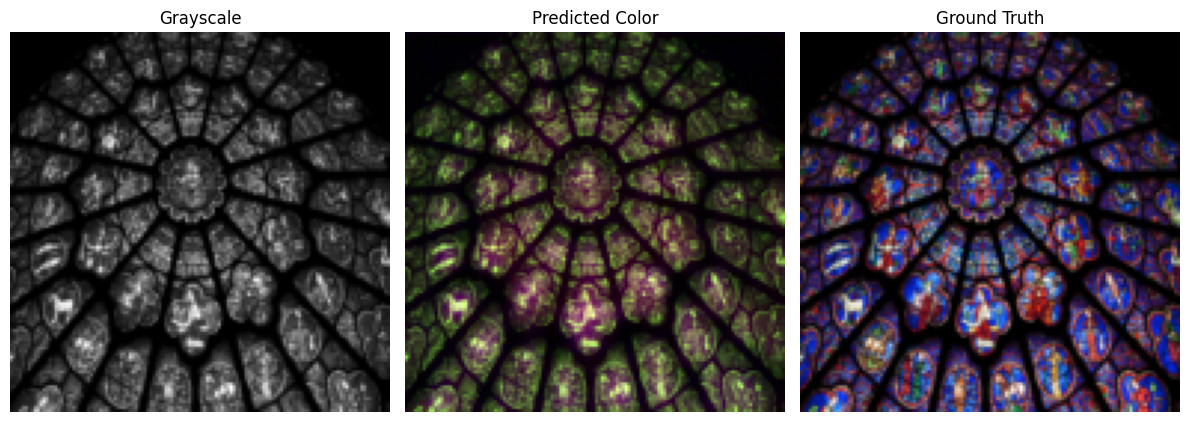

Predicting test_imgs/jerry.jpg


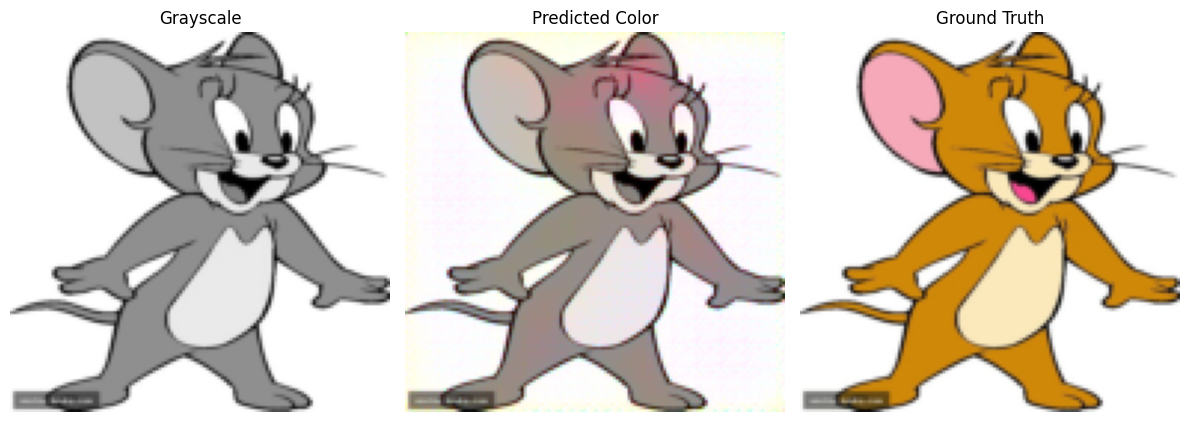

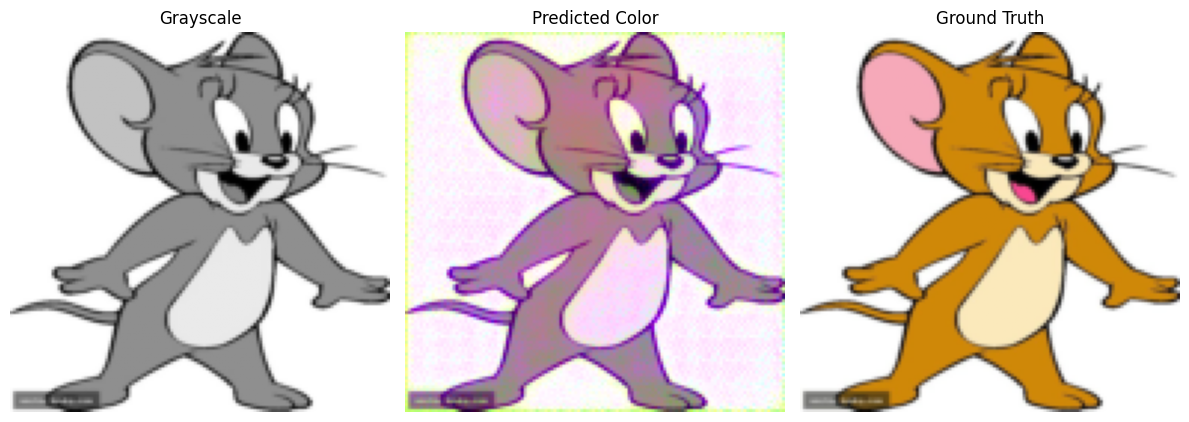

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load model
hybrid_model = load_model(HybridColorizationCNN, "hybrid_colorizer.pth", device)
base_model = load_model(BaseColorizationCNN, "base_colorizer.pth", device)

# Precompute values for prediction
w = torch.tensor([0.299, 0.587, 0.114], device=device)
u1, u2 = compute_orthonormal_basis(w, device=device)

# === Test on new images in directory ===
# img_dir = "test_imgs"
# img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
# for img_path in img_paths:
#     print(f"Predicting {img_path}")
#     test_img = Image.open(img_path)
#     predict_single_image(hybrid_model, test_img, w, u1, u2, device);
#     predict_single_image(base_model, test_img, w, u1, u2, device);

# === Test on single image ===
# test_img = Image.open("test.jpg")
# predict_single_image(hybrid_model, test_img, w, u1, u2, device);
# predict_single_image(base_model, test_img, w, u1, u2, device);

# === Test on dataset images ===
# train_loader, test_loader = load_cifar10(batch_size=64)
# train_loader, test_loader = load_flowers102(batch_size=64)
# train_loader, test_loader = load_stl10(batch_size=64)

# print("Hybrid")
# predict_dataset_images(hybrid_model, test_loader, w, u1, u2, device, num_images=10, randomize=False)
# print("Base")
# predict_dataset_images(base_model, test_loader, w, u1, u2, device, num_images=10, randomize=False)
